In [32]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook
from itertools import product
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.1
pandas 0.23.2
sklearn 0.19.1
scipy 1.0.0
lightgbm 2.1.0
seaborn 0.8.1


## Load Data

In [33]:
df_sales = pd.read_csv('./data/sales_train.csv.gz')
df_shops = pd.read_csv('./data/shops.csv')
df_items = pd.read_csv('./data/items.csv')
df_item_cats = pd.read_csv('./data/item_categories.csv')
df_test = pd.read_csv('./data/test.csv.gz')

## Exploratory Data Analysis (EDA)

In [34]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [35]:
df_items.shape

(22170, 3)

In [36]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [37]:
df_shops.shape

(60, 2)

In [38]:
df_item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [39]:
df_item_cats.shape

(84, 2)

In [40]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [41]:
df_sales.shape

(2935849, 6)

In [42]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [43]:
df_test.shape

(214200, 3)

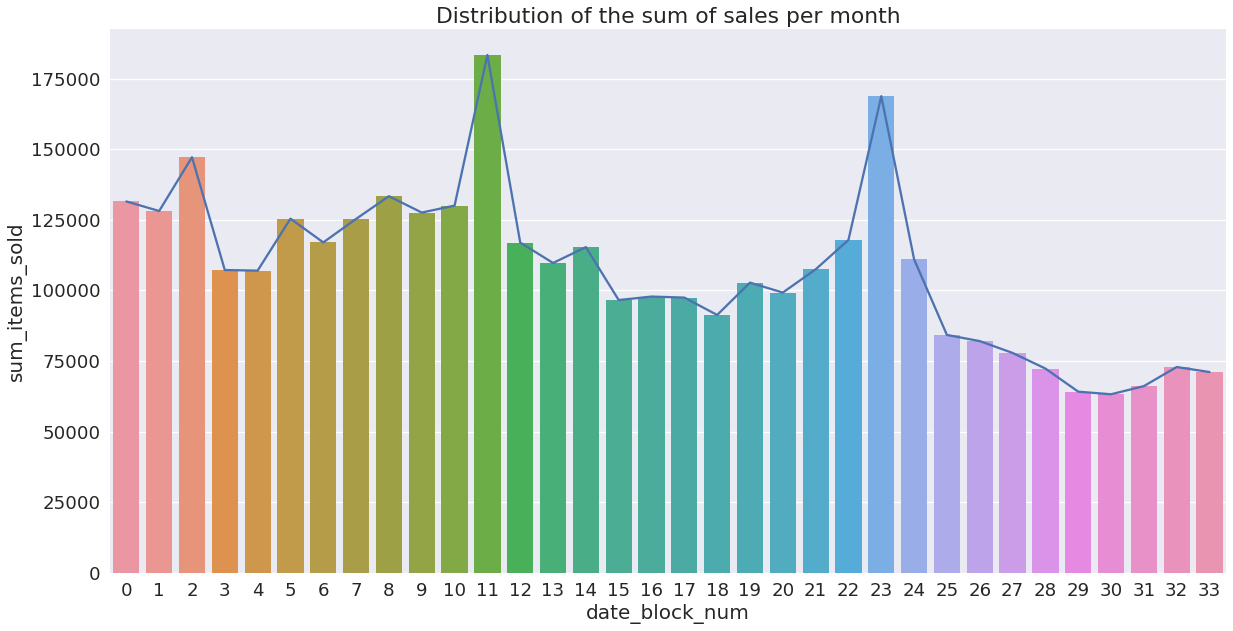

In [44]:
sns.set_context("talk", font_scale=1.4)

df_sales_month = pd.DataFrame(df_sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
df_sales_month.columns = ['date_block_num', 'sum_items_sold']

sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=df_sales_month.reset_index());
plt.plot(df_sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')

del df_sales_month

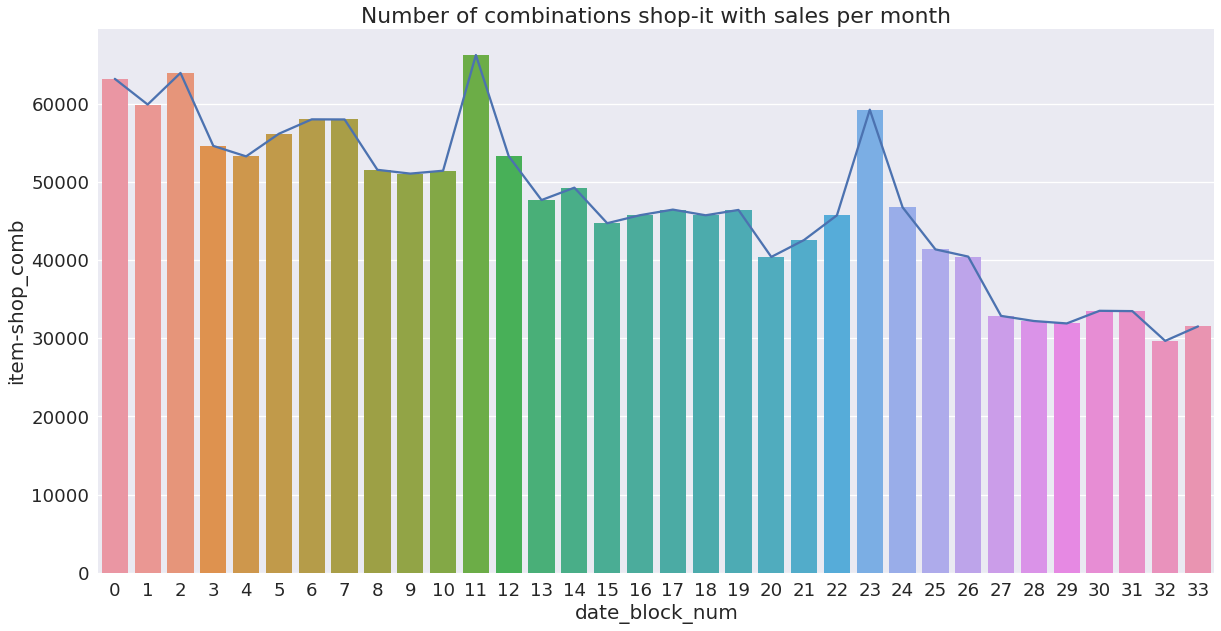

In [45]:
df_comb_shop_item = pd.DataFrame(df_sales[['date_block_num', 'shop_id', 'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
df_comb_shop_item.columns = ['date_block_num', 'item-shop_comb']

sns.barplot(x ='date_block_num', y='item-shop_comb', data=df_comb_shop_item)
plt.plot(df_comb_shop_item['item-shop_comb'])
plt.title('Number of combinations shop-it with sales per month')

del df_comb_shop_item

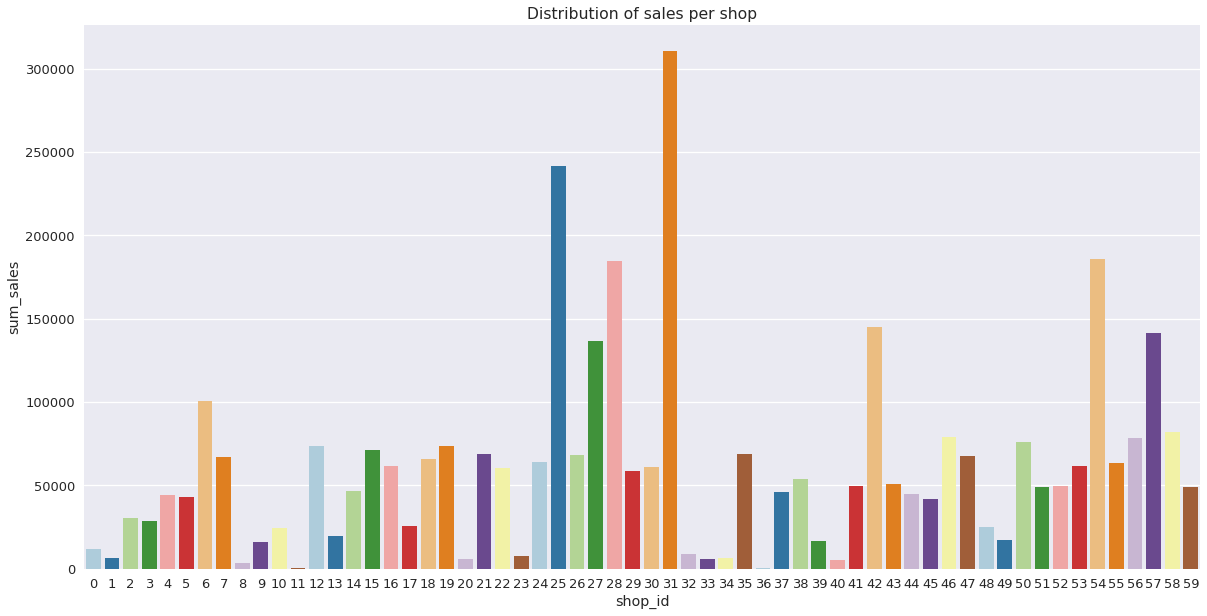

In [46]:
sns.set_context("talk", font_scale=1)

df_sales_month_shop_id = pd.DataFrame(df_sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
df_sales_month_shop_id.columns = ['shop_id', 'sum_sales']

sns.barplot(x ='shop_id', y='sum_sales', data=df_sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop')

del df_sales_month_shop_id

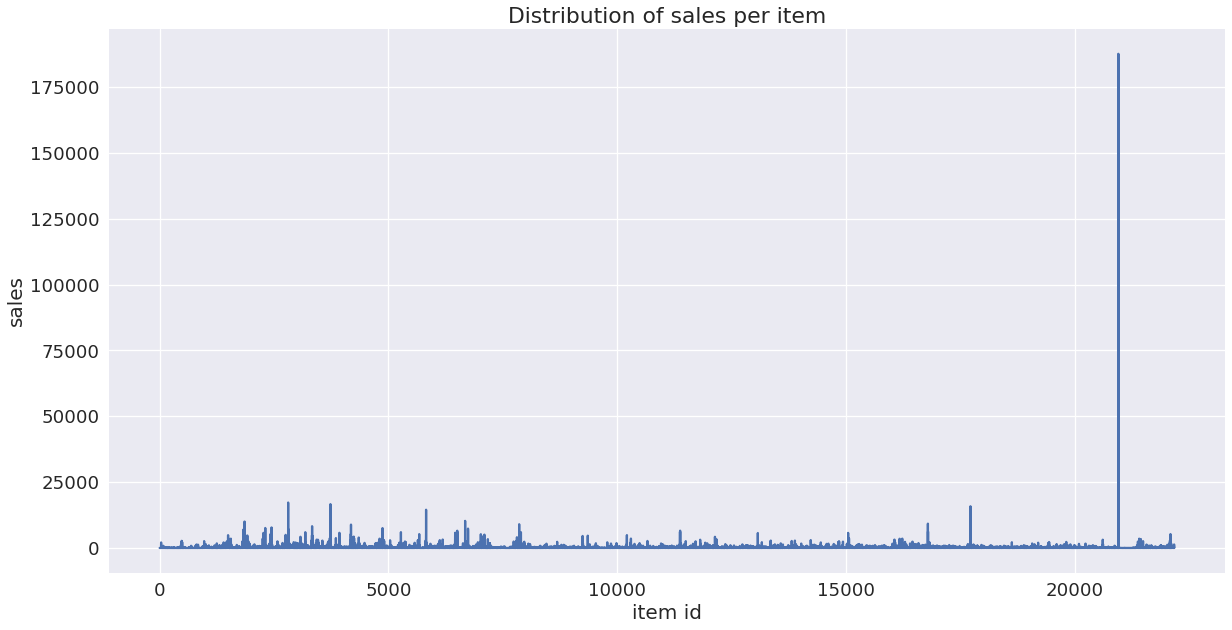

In [47]:
sns.set_context("talk", font_scale=1.4)

df_sales_item_id = pd.DataFrame(df_sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.title('Distribution of sales per item')

plt.plot(df_sales_item_id)

In [48]:
id_anomaly_item = df_sales_item_id['item_cnt_day'].argmax()
id_anomaly_item

20949

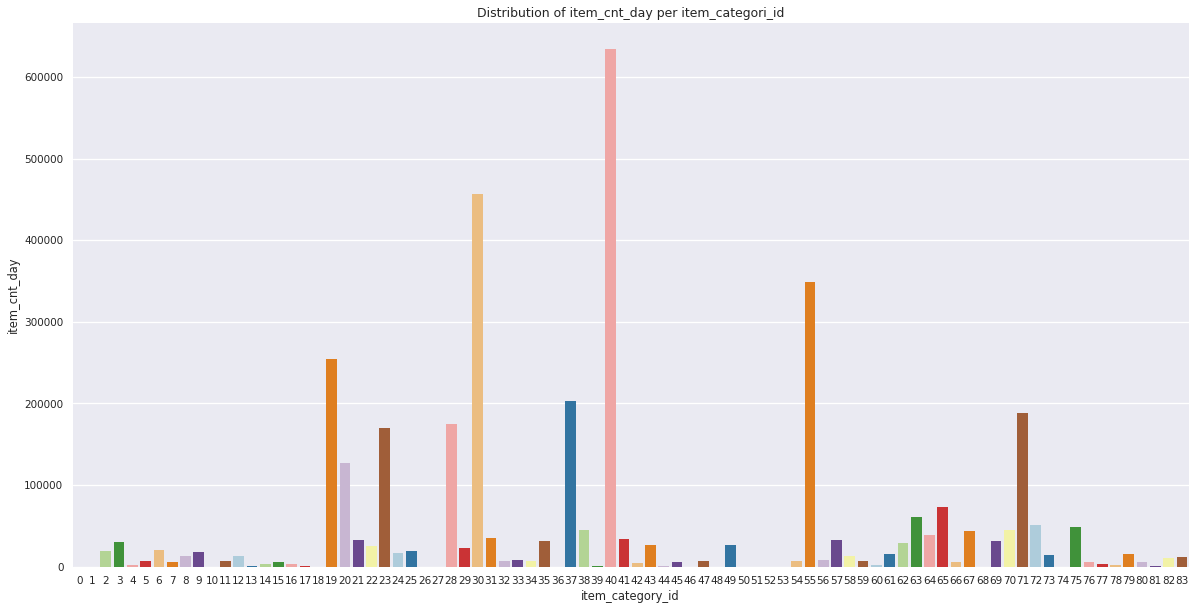

In [49]:
#fig, ax = plt.subplots()
sns.set_context("talk", font_scale=0.8)

df_sales_item_cat = df_sales.merge(df_items, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day', data=df_sales_item_cat.reset_index(), palette='Paired')

plt.title('Distribution of item_cnt_day per item_categori_id')

del df_sales_item_cat

## Feature Engineering

In [50]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols   = [c for c in df if df[c].dtype == "int64"]
    
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [51]:
def rmse(*args):
    return np.sqrt(mean_squared_error(*args))

In [52]:
def get_feature_matrix(sales, test, items, list_lags, date_block_threshold):
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations
    grid = [] 
    new_items = pd.DataFrame()
    cur_items_aux=np.array([])
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
        cur_items_aux = cur_items[pd.Series(cur_items).isin(test.item_id)]
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Add submission shop_id-item_id to predictions
    test['date_block_num'] = 34
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    # Get shop-item-month aggregates
    gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Get shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    
    # Join it to the grid
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Get item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    
    del grid, gb 
    
    gc.collect()
    
    # Get column names
    cols_to_rename = list(all_data.columns.difference(index_cols)) 

    shift_range = list_lags

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    # Don't use old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= date_block_threshold] 

    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # Get categories
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, to_drop_cols]

In [55]:
list_lags = [1, 2, 3]
date_block_threshold = 12

df_sales_for_modelling = df_sales[df_sales['item_id'].isin(df_test['item_id'])]

[df_all_data, listto_drop_cols] = get_feature_matrix(df_sales_for_modelling, df_test, df_items, list_lags, date_block_threshold)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [56]:
df_all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55


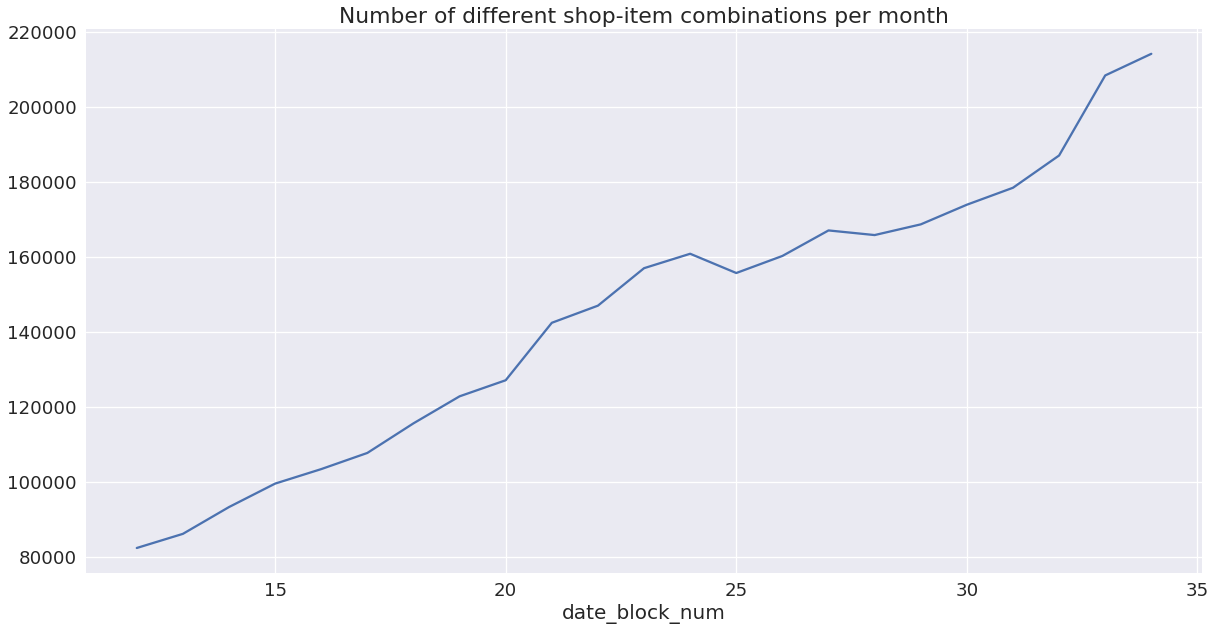

In [57]:
sns.set_context("talk", font_scale=1.4)
plt.title('Number of different shop-item combinations per month')

df_all_data.groupby('date_block_num').size().plot()

* mean / variance encoding for category-id last month

In [60]:
df_mean_enc_item_cat = pd.DataFrame(df_all_data.groupby(['shop_id', 'item_category_id']).target.agg(['mean', 'var']).reset_index())
df_mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']

df_all_data = pd.merge(df_all_data, df_mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])

del df_mean_enc_item_cat

df_all_data = downcast_dtypes(df_all_data)

In [61]:
df_all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id_x,var_enc_cat_id_x,mean_enc_cat_id_y,var_enc_cat_id_y
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37,0.512281,2.742767,0.512281,2.742767
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40,1.120868,10.631319,1.120868,10.631319
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37,0.512281,2.742767,0.512281,2.742767
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40,1.120868,10.631319,1.120868,10.631319
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55,0.902726,2.715576,0.902726,2.715576


In [62]:
df_all_data.shape

(3324774, 20)

## Train, Validation, Test sets preparation

In [63]:
df_sub_data = df_all_data[df_all_data.date_block_num==34].fillna(0)
df_all_data = df_all_data[df_all_data.date_block_num<34].fillna(0)
df_sub_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id_x,var_enc_cat_id_x,mean_enc_cat_id_y,var_enc_cat_id_y
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459,1.095659,11.922459


In [66]:
dates = df_all_data['date_block_num']
boolean_test = (dates.isin([22,31,32,33])) 
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = df_all_data.loc[boolean_train].drop(listto_drop_cols, axis=1)
X_val   = df_all_data.loc[boolean_test].drop(listto_drop_cols, axis=1)

y_train = df_all_data.loc[boolean_train, 'target'].values
y_val   = df_all_data.loc[boolean_test, 'target'].values

In [67]:
listto_drop_cols

['target', 'target_shop', 'target_item', 'date_block_num']

In [68]:
X_train.shape

(2389620, 16)

In [69]:
X_val.shape

(720954, 16)

In [72]:
tuples_validation_submission = pd.Series(list(X_val[['item_id', 'shop_id']][dates_val==33].itertuples(index=False, name=None)))

In [74]:
tuples_df = pd.Series(list(df_sales[['item_id', 'shop_id']].itertuples(index=False, name=None)))
tuples_test = pd.Series(list(df_test[['item_id', 'shop_id']].itertuples(index=False, name=None)))

In [75]:
print(f'Cross-validation is the {round(X_val.shape[0]/X_train.shape[0],2)*100} %' )
print(f'The {round(tuples_test.isin(tuples_validation_submission).sum()/len(tuples_test),2)*100} % of the item_id-shop_id are in the cv set ')

Cross-validation is the 30.0 %
The 93.0 % of the item_id-shop_id are in the cv set 


## Modelling

* LightGBM

In [76]:
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
best_rmse = 9999999999999

for lr in learning_rates:
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=np.clip(y_train, 0, 40)), int(100 * (lr / 0.03)))
    
    pred_lgb_val = lgb_model.predict(X_val)
    
    score = rmse(np.clip(y_val, 0, 20), np.clip(pred_lgb_val, 0, 20))

    if score < best_rmse:
        best_rmse = score
        best_lr = lr
        best_lgb = lgb_model

In [77]:
best_lr

0.02

In [78]:
X = X_train.append(X_val)
y = np.append(y_train, y_val)

In [79]:
best_lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': best_lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

best_lgb = lgb.train(lgb_params, lgb.Dataset(X, label=np.clip(y, 0, 40)), int(100 * (lr / 0.03)))

In [80]:
filename = './models/best_lgb.model'
pickle.dump(best_lgb, open(filename, 'wb'))

* Random Forest

In [82]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

X = X_train.append(X_val)
Y = np.concatenate([y_train, y_val])
train_ind=np.zeros(X.shape[0])

for i in range(0, len(X_train)):
    train_ind[i] = -1

ps = PredefinedSplit(test_fold=(train_ind))

In [83]:
param_grid={'bootstrap':[0.7, 0.8], 'max_features':[4, 6, 8], 
            'max_depth' : [None, 4, 6, 8, 10, 12]}

gs = GridSearchCV(cv = ps, 
                  estimator = RandomForestRegressor(n_estimators=300, n_jobs=4), 
                  param_grid=param_grid, scoring='neg_mean_squared_error')

In [84]:
gs.fit(X, np.clip(Y, 0, 40))
best_rf = gs.best_estimator_

In [85]:
best_rf

RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [86]:
best_rf.fit(X, np.clip(y, 0, 40))

RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [87]:
filename = './models/best_rf.model'
pickle.dump(best_rf, open(filename, 'wb'))

* stacking

In [88]:
rf = pickle.load(open('./models/best_rf.model', 'rb'))
lgb = pickle.load(open('./models/best_lgb.model', 'rb'))

In [89]:
def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 20)

In [90]:
pred_lgb_val = lgb.predict(X_val)
print('Train RMSE for lgb is  %f' % rmse(clip20(y_train), clip20(lgb.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Train RMSE for lgb is  0.853796
Val RMSE for lgb is 0.824783


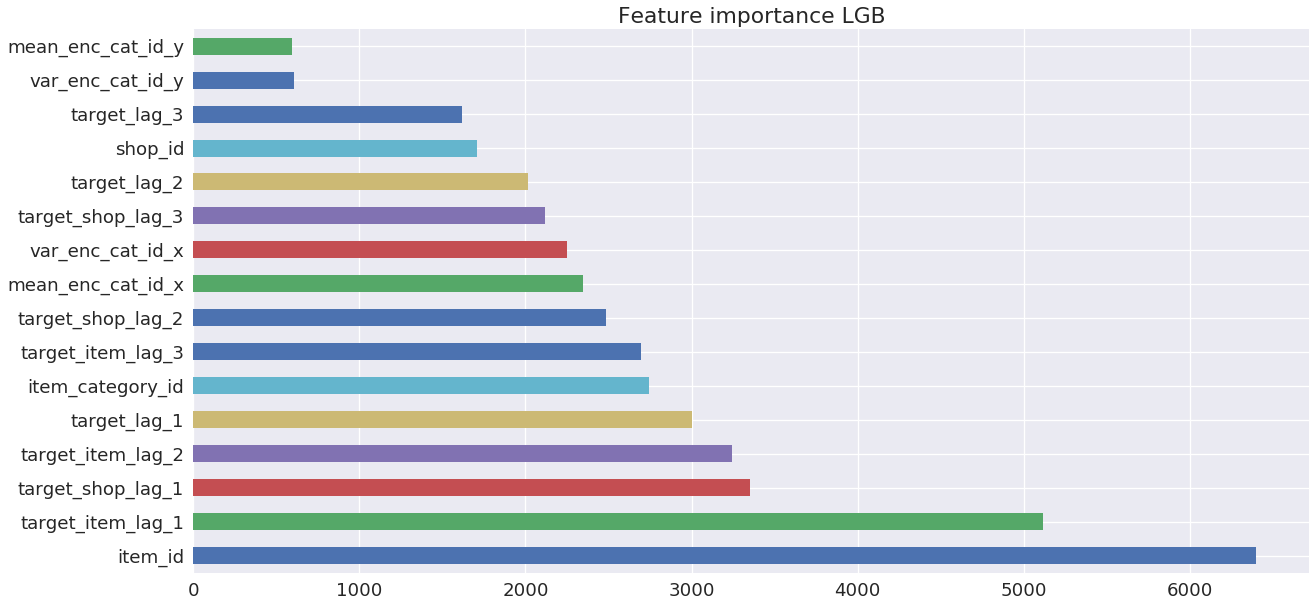

In [91]:
feat_importances = pd.Series(lgb.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

In [92]:
pred_rf_val = clip20(rf.predict(X_val.fillna(0)))
print('Train RMSE for rf is %f' % rmse(clip20(y_train), clip20(rf.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip20(y_val), pred_rf_val))

Train RMSE for rf is 0.942000
Val RMSE for rf is 0.889343


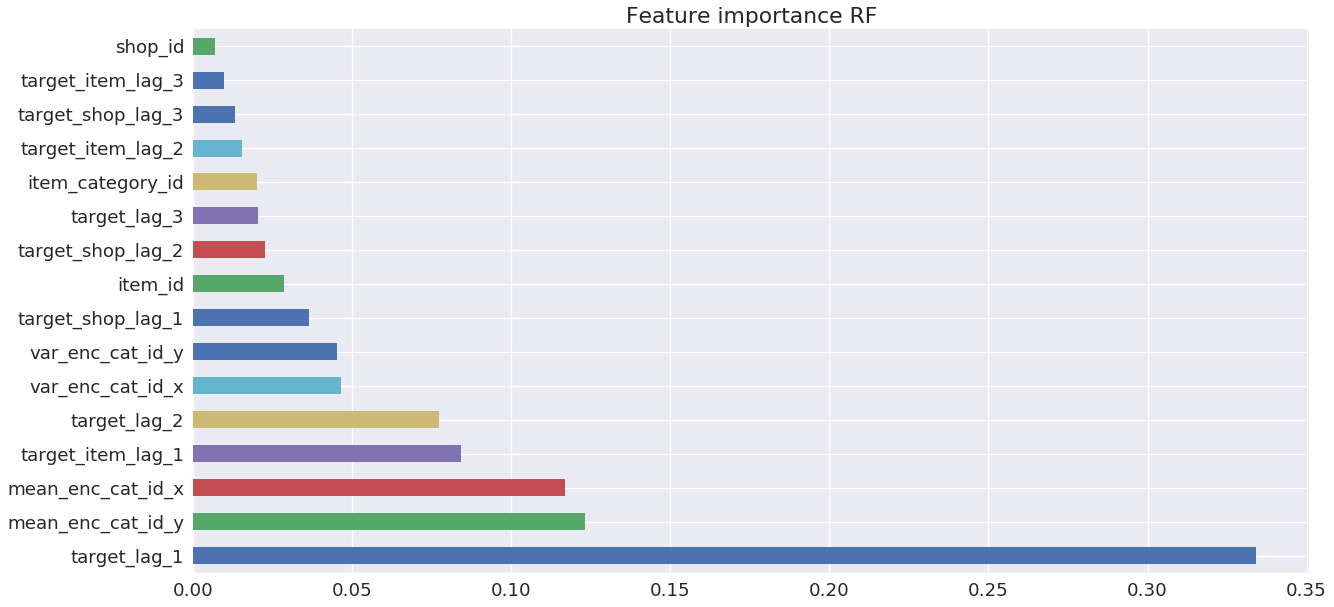

In [93]:
feat_importances = pd.Series(rf.feature_importances_, index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance RF')
plt.show()

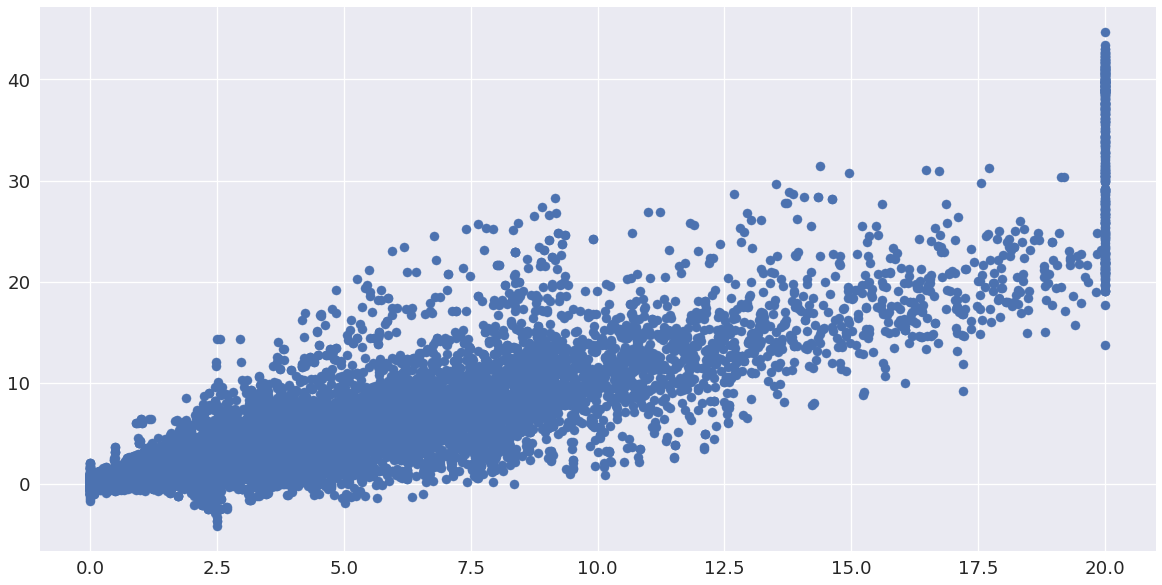

In [94]:
plt.scatter(pred_rf_val, pred_lgb_val)

In [95]:
X_val_level2 = np.c_[pred_rf_val, pred_lgb_val]

In [96]:
lr = LinearRegression()
lr.fit(X_val_level2, clip40(y_val))
pred_lr_val =  clip20(lr.predict(X_val_level2))
print('Test rmse for stacking variables is %f' % rmse(clip20(y_val), clip20(pred_lr_val)))

Test rmse for stacking variables is 0.830772


## Submission

In [99]:
pred_test_rf = rf.predict(df_sub_data.drop(listto_drop_cols, axis=1).fillna(0))

In [101]:
pred_test_lgb = lgb.predict(df_sub_data.drop(listto_drop_cols, axis=1).fillna(0))

In [102]:
X_test_level2 = np.c_[pred_test_rf, pred_test_lgb]

In [103]:
test_pred = clip20(lr.predict(X_test_level2))

In [104]:
test_pred.mean()

0.30369373215313633

In [107]:
predictions = pd.DataFrame()
predictions['shop_id'] = df_test.shop_id
predictions['item_id'] = df_test.item_id
predictions['item_cnt_month'] = test_pred
submision = df_test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('./submission/submission_stacking_v2.csv',index=False)